# Прогнозирование загрязнения воздуха

Набор данных: Air Quality
    
Это набор данных, который сообщает о погоде и уровне загрязнения каждый час в течение пяти лет в посольстве США в Пекине, Китай.

Состоит из:
- нет: номер строки
- год: год данных в этой строке
- месяц: месяц данных в этой строке
- день: день данных в этой строке
- час: час данных в этой строке
- РМ2,5: Концентрация PM2,5
- Dewp: Точка росы
- TEMP: Температура
- ПРЕС: Давление
- cbwd: Комбинированное направление ветра
- IWS: Накопленная скорость ветра
- Является: Накопленные часы снега
- инфракрасный: Накопленные часы дождя

Задача: учитывая погодные условия и загрязнение за предыдущие часы, спрогнозировать загрязнение на следующий час.

### 1. Загрузка данных

In [1]:
import pandas
from datetime import datetime
from matplotlib import pyplot

def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = pandas.read_csv('C:/Users/User/Desktop/pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)

In [2]:
# вручную указать имена столбцов
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

In [3]:
# заменить все значения NA на 0
dataset['pollution'].fillna(0, inplace=True)

In [4]:
# сбросить первые 24 часа
dataset = dataset[24:]

In [5]:
print(dataset.head(5))

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [6]:
# сохранить в файл
dataset.to_csv('C:/Users/User/Desktop/pollution_1.csv')

График с 7 подзадачами, показывающими данные за 5 лет для каждой переменной


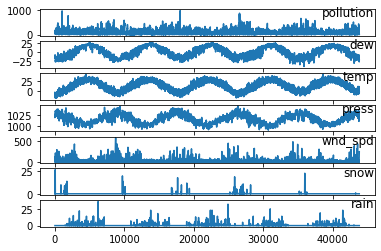

In [7]:
dataset = pandas.read_csv('C:/Users/User/Desktop/pollution_1.csv', header=0, index_col=0)
values = dataset.values
# укажите столбцы для построения
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot каждый столбец
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
print('График с 7 подзадачами, показывающими данные за 5 лет для каждой переменной')
pyplot.show()

### 2. Подготовка данных 

In [8]:
from sklearn import preprocessing

# преобразовать серию в supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pandas.DataFrame(data)
    cols, names = list(), list()
    # ввод sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # соединить
    agg = pandas.concat(cols, axis=1)
    agg.columns = names
    # удалить строки со значениями NaN
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
values = dataset.values
# integer encode direction
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# убедиться, что все данные float
values = values.astype('float32')
# нормализовать функции
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# удалить столбцы, которые мы не хотим предсказывать
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [16]:
# Чтобы ускорить обучение модели для этой демонстрации, мы подгоним модель только к первому году данных, 
# а затем оценим ее по оставшимся четырем годам данных. 

In [9]:
# разделить на train и test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# разделить на input и outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# изменить input на 3D [samples, timesteps, features]
# преобразовать в 3D-формат, ожидаемый LSTM, а именно: [выборки, временные шаги, функции].
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


### 3. Создание модели для обучения

In [10]:
import tensorflow as tf
from tensorflow import keras

In [11]:
# Мы определим LSTM с 50 нейронами в первом скрытом слое и 1 нейроном в выходном слое для прогнозирования загрязнения. 
# Форма ввода будет 1 временной шаг с 8 функциями.
model = keras.Sequential()
model.add(keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(keras.layers.Dense(1))
# Мы будем использовать функцию потерь «Средняя абсолютная ошибка» (MAE) и 
# эффективную версию Адама для стохастического градиентного спуска.
model.compile(loss='mae', optimizer='adam')

### 4. Обучение модели

In [12]:
# Модель будет подходить для 50 тренировочных эпох с размером партии 72.
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
122/122 - 1s - loss: 0.0589 - val_loss: 0.0790
Epoch 2/50
122/122 - 0s - loss: 0.0403 - val_loss: 0.0890
Epoch 3/50
122/122 - 0s - loss: 0.0273 - val_loss: 0.0750
Epoch 4/50
122/122 - 0s - loss: 0.0204 - val_loss: 0.0593
Epoch 5/50
122/122 - 1s - loss: 0.0171 - val_loss: 0.0475
Epoch 6/50
122/122 - 0s - loss: 0.0160 - val_loss: 0.0360
Epoch 7/50
122/122 - 0s - loss: 0.0154 - val_loss: 0.0266
Epoch 8/50
122/122 - 0s - loss: 0.0151 - val_loss: 0.0214
Epoch 9/50
122/122 - 0s - loss: 0.0149 - val_loss: 0.0200
Epoch 10/50
122/122 - 0s - loss: 0.0148 - val_loss: 0.0182
Epoch 11/50
122/122 - 0s - loss: 0.0148 - val_loss: 0.0161
Epoch 12/50
122/122 - 0s - loss: 0.0148 - val_loss: 0.0153
Epoch 13/50
122/122 - 0s - loss: 0.0147 - val_loss: 0.0150
Epoch 14/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0150
Epoch 15/50
122/122 - 0s - loss: 0.0147 - val_loss: 0.0144
Epoch 16/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0143
Epoch 17/50
122/122 - 0s - loss: 0.0147 - val_loss: 0.0143
Epoch 

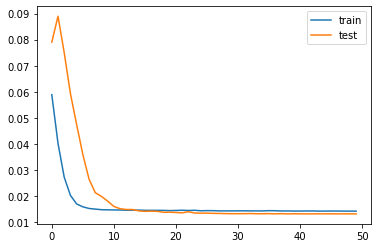

In [13]:
# plot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### 5. Оценить модель

In [14]:
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.433


In [17]:
# После подгонки модели мы можем прогнозировать весь набор тестовых данных.

# Мы объединяем прогноз с тестовым набором данных и инвертируем масштабирование. Мы также инвертируем масштабирование 
# на тестовом наборе данных с ожидаемыми значениями загрязнения.

# С прогнозами и фактическими значениями в их первоначальном масштабе мы можем затем рассчитать оценку ошибки для модели. 
# В этом случае мы вычисляем среднеквадратичную ошибку (RMSE), которая дает ошибку в тех же единицах, что и сама переменная.

In [18]:
# вывод:
# Мы можем видеть, что модель достигает респектабельного RMSE 26.433, что ниже, чем среднеквадратичное 
# значение 30, найденное для модели постоянства.

# Изучили:
# - Как преобразовать необработанный набор данных в нечто, что мы можем использовать для прогнозирования временных рядов.
# - Как подготовить данные и приспособить LSTM к проблеме прогнозирования многомерных временных рядов.
# - Как сделать прогноз и масштабировать результат обратно в исходные единицы.

* Арима
* Регрессия
* НН (сверточная, лтсм, обычная, рекурентная)
* составить таблицу ( mse, mae, mape) - для каждого вида
( metrics=['accuracy'] )
1 модель = 2 балла
5 моделей

* лаб 6 - посмотреть в блокноте
* там выполнить задания (4)
* https://drive.google.com/drive/folders/1uLHLBqhS5J34qcuW6pmDlvVMB806fRSU

лаб 7 - любая выборка, прогнать по кохонену

22 и 29 зачет - нужен проект по экономике или по диплому